In [18]:
import flopy as fp
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
import shapely
from flopy.utils.gridintersect import GridIntersect
import os

this notebook import and work with MNT (tif/grd) files in order to provide the top of the 1st layer and have a pseudo 3D model

In [19]:
model_dir = "working"
model_name="dis_test"
exe_name="../../exe.mf6"

add basic parameters

In [20]:
x0 = 660000 # left min
x1 = 705000 # right max
Lx = x1-x0
y0 = 6150000 # bottom min
y1 = 6205000 # top max
Ly = y1-y0
nlay=1
ncol = nrow = 100
delr = np.ones(ncol)*(Lx/ncol)
delc = np.ones(ncol)*(Ly/nrow)
botm=-100
top=100
idomain = np.zeros((nrow*ncol))

R_path="../data/limiteModeleRoussillon_poly.shp"


Import the MNT (only tif at this moment)

In [21]:
# import a mnt and use it to
from PIL import Image
#im = Image.open("../data/MNT_demo_5m.tif")
im = Image.open("../../../../../MNT25_Ticino.tif") #I didn't have the mnt... better than nothing :)

extract data into an array with numpy, assign None value where there's no data and retrieve MNT's resolution

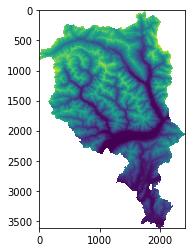

In [33]:
imar = np.array(im)
imar[imar<=0]=None
plt.imshow(imar)

ny,nx = imar.shape
dx = Lx/nx
dy = Ly/ny

Create a fake simulation pack in order to make some plots

In [24]:
simfake = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name=exe_name, 
                             sim_ws=model_dir)
gwffake = fp.mf6.ModflowGwf(simfake, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwffake, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0,idomain=idomain)

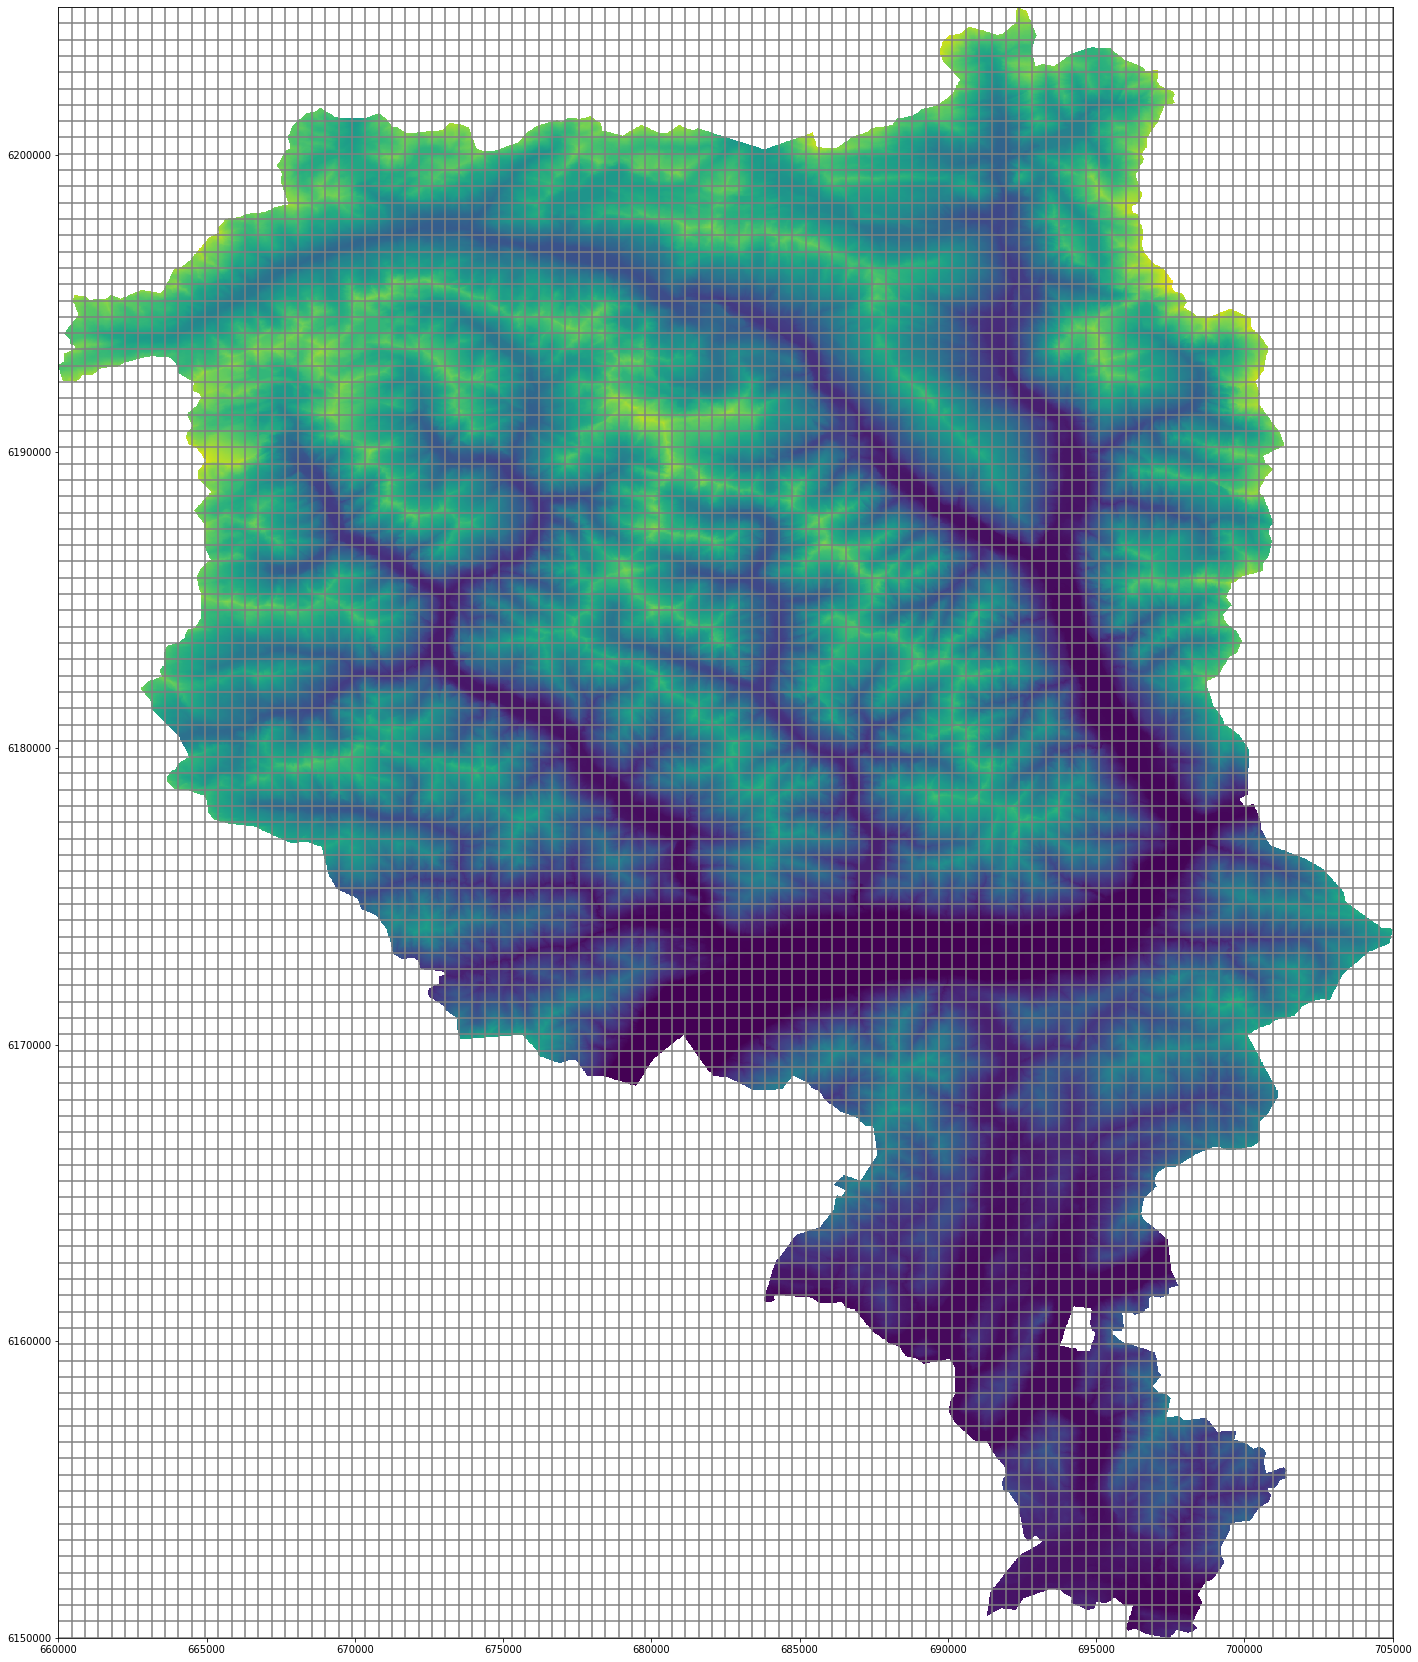

In [25]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(aspect='equal')
mm = fp.plot.PlotMapView(model=gwffake)
mm.plot_grid()
#fp.plot.plot_shapefile(R_path,ax=ax,facecolor="blue")
ax.imshow(imar,extent=(x0,x1,y0,y1))

### this function reduce the resolution of an image (image should be an array of a form (nx,ny)) to the size (nrow, ncol)
P.S nodata must be declared as "None" dtype

In [26]:
def Imreduction (imar, nrow, ncol):
    #first define the ratio between the given and the desired resolution in x and y
    facR=imar.shape[0]/nrow
    facC=imar.shape[1]/ncol
    
    # go through the entire grid (nrow,ncol) and use the mean of all the values in the array image
    # in a specific cell of the grid (i,o)
    new_imar=[]
    for i in range(nrow):
        for o in range(ncol):
            new_val=np.nanmean(imar[np.round(i*facR).astype(int):np.round(i*facR+facR).astype(int),
                                    np.round(o*facC).astype(int):np.round(o*facC+facC).astype(int)])
            new_imar.append(new_val)
    
    # create an array of the new image array
    new_imar = np.array(new_imar)
    return new_imar.reshape(nrow,ncol)

In [28]:
new_imar = Imreduction(imar,nrow,ncol)

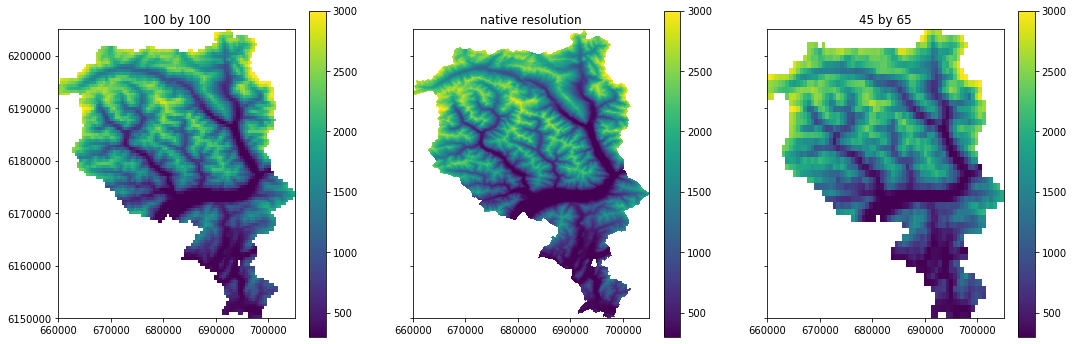

In [42]:
fig,ax=plt.subplots(1,3,sharey=True,figsize=(18,6))

g=ax[0].imshow(new_imar.reshape(nrow,ncol),extent=(x0,x1,y0,y1))
fig.colorbar(g,ax=ax[0])
ax[0].set(title=("100 by 100"))
g.set_clim(300,3000)

h=ax[1].imshow(imar,extent=(x0,x1,y0,y1))
plt.colorbar(h,ax=ax[1])
ax[1].set(title=("native resolution"))
h.set_clim(300,3000)

j = ax[2].imshow(Imreduction(imar,45,65),extent=(x0,x1,y0,y1))
plt.colorbar(j)
ax[2].set(title=("45 by 65"))
j.set_clim(300,3000)